In [1]:
import parser
from pprint import pprint

from IPython.display import Image, display
from lark import Lark, Tree, Token, Transformer, v_args
from lark import tree as larkTree
from lark.indenter import Indenter

import os

NOTES_FOLDER = './note_files/'
NOTE_PATHS = [x for x in os.listdir(NOTES_FOLDER) if x.endswith('.md')]

def display_tree(t, filename='viz.png'):
    larkTree.pydot__tree_to_png(t, filename)
    display(Image(filename))
    os.remove(filename)

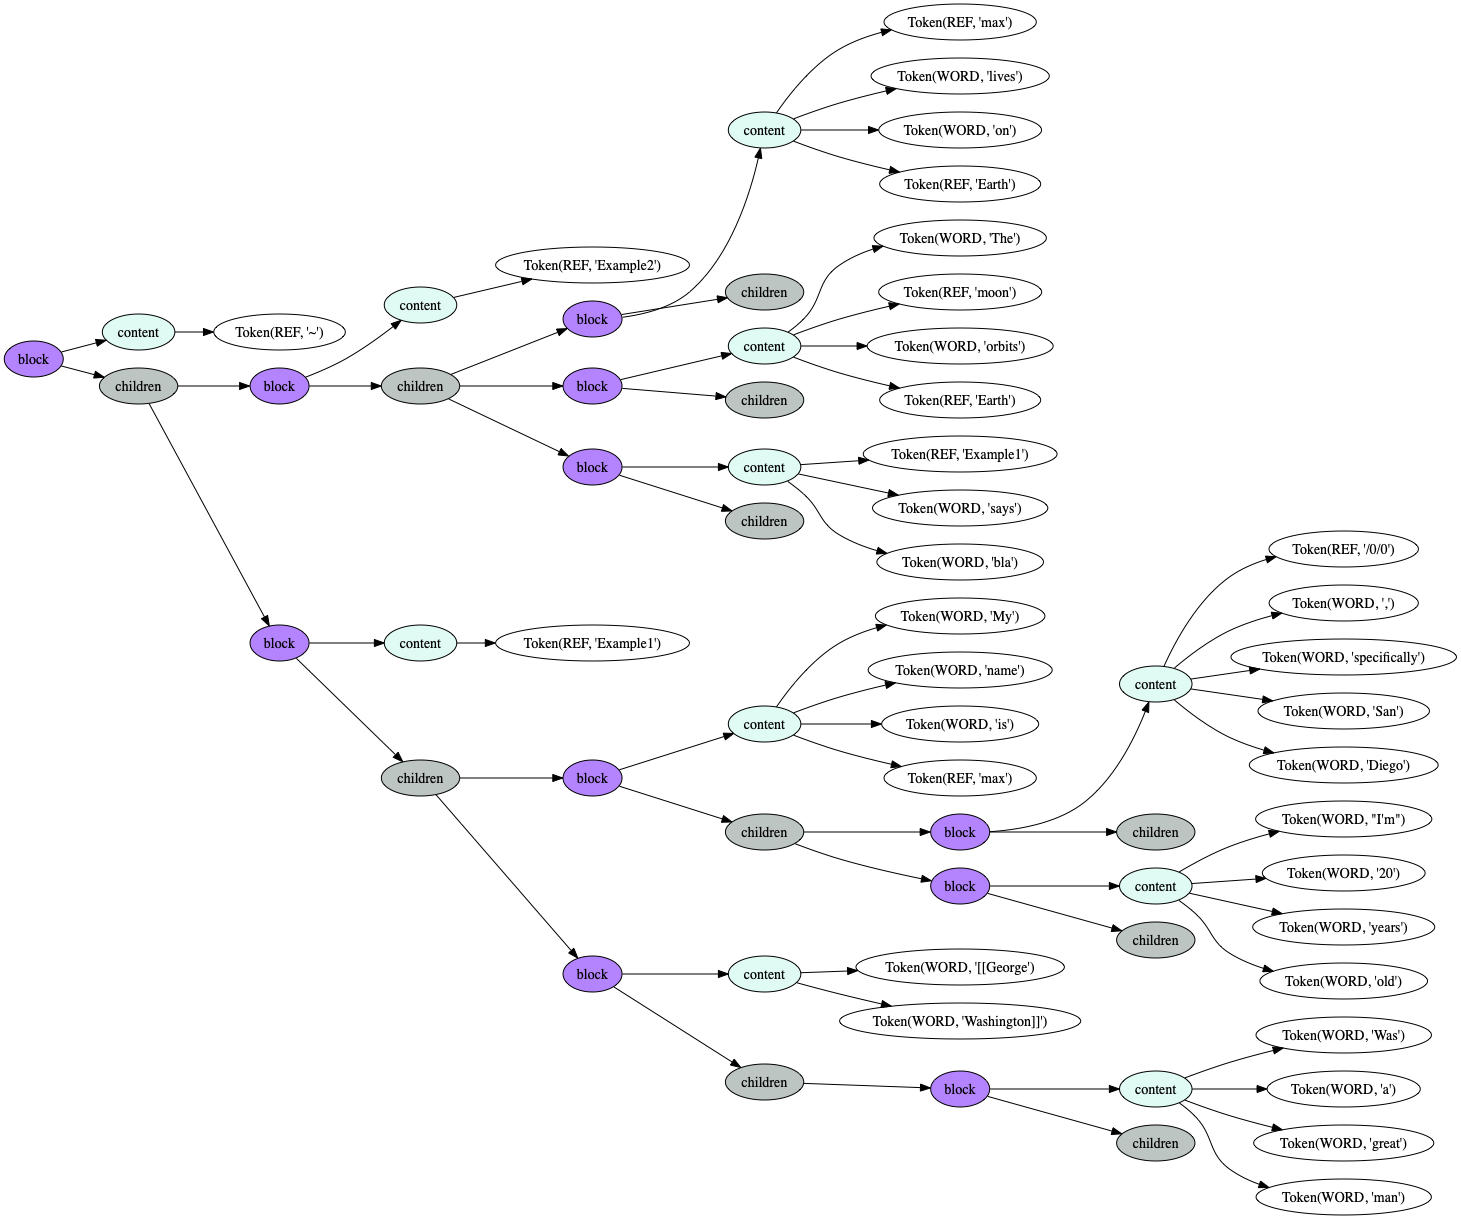

In [24]:
class TreeIndenter(Indenter):
    NL_type = '_NL'
    OPEN_PAREN_types = []
    CLOSE_PAREN_types = []
    INDENT_type = '_INDENT'
    DEDENT_type = '_DEDENT'
    tab_len = 2
    
class BTransformer(Transformer):
    def value(self, args):
        token = args[0]
        token_value = str(token)
        if token.type == 'REF':
            token_value = token_value.replace('[[', '').replace(']]', '')
        return Token(token.type, token_value)


class Block:
    
    def __init__(self, content, children=[]):
        self.content = content
        self.children = children

        
    def fromTree(blockTree):
        content = blockTree.children[0].children
        children = blockTree.children[1].children
        children = [Block.fromTree(x) for x in children]
                
        return Block(content, children)
    
    def toTree(self):
        children_node = Tree(data='children', children=[x.toTree() for x in self.children])
        content_node = Tree(data='content', children=self.content)
        return Tree(data='block',
                   children=[content_node, children_node])
    
    def to_dict(self):
        children = [x.to_dict() for x in self.children]
        content = []
        for token in self.content:
            content.append({
                'type': token.type,
                'value': str(token)
            })
        return {
            'type': 'block',
            'children': children,
            'content': content
        }
    
    def show(self):
        display_tree(self.toTree())
    
# GRAMMAR = open('grammar.lark').read()
GRAMMAR = r"""
    ?start: (_NL* block)* -> children
    
    block: "- " content _NL children
    children: [_INDENT block* _DEDENT]
    content: value*
    value: WORD | REF -> value
    
    REF: /\[\[/ [WORD] /\]\]/
    WORD: /\S+/
    
    %declare _INDENT _DEDENT
    %import common.WS_INLINE
    %ignore WS_INLINE
    _NL: /(\r?\n(\s)*)+/
"""

PARSER = Lark(
    GRAMMAR,
    parser='lalr',
    postlex=TreeIndenter(),
    transformer=BTransformer())


def parse_blocks(text):
    return PARSER.parse(text).children


def parse_notefile(note_path):
    text = open(note_path).read() + '\n'
    note_title = os.path.basename(note_path).replace('.md', '')
    blocks = [Block.fromTree(x) for x in parse_blocks(text)]
    root_text = [Token('REF', note_title)]
    return Block(content=root_text, children=blocks)


def parse_notefiles(folder_path):
    paths = [x for x in os.listdir(folder_path) if x.endswith('.md')]
    note_blocks = []
    for path in paths:
        note_title = path.replace('.md', '')
        note_tree = parse_notefile(NOTES_FOLDER + path)
        note_blocks.append(note_tree)
    return Block(content=[Token('REF', value='~')], children=note_blocks)
    

NOTES_FOLDER = './note_files/'
notes_data = parse_notefiles(NOTES_FOLDER)
notes_data.show()


In [9]:
def flatten_blocks(block, path=''):
    results = {}
    block_text = block.content
    block_children = block.children
    results[path] = block
    for i, b in enumerate(block_children):
        results.update(flatten_blocks(b, path + '/' + str(i)))
    return results

all_blocks = flatten_blocks(notes_data)
all_blocks

{'': <__main__.Block at 0x104baee10>,
 '/0': <__main__.Block at 0x104ddf0d0>,
 '/0/0': <__main__.Block at 0x104a3fa90>,
 '/0/1': <__main__.Block at 0x104bae810>,
 '/0/2': <__main__.Block at 0x104bae8d0>,
 '/1': <__main__.Block at 0x104de4e10>,
 '/1/0': <__main__.Block at 0x104bae210>,
 '/1/0/0': <__main__.Block at 0x104df2850>,
 '/1/0/1': <__main__.Block at 0x104df2410>,
 '/1/1': <__main__.Block at 0x104df2fd0>,
 '/1/1/0': <__main__.Block at 0x104deb2d0>}

In [4]:
def get_refs(blocks, recursive=False):
    all_refs = set()
    for block in blocks:
        for token in block.content:
            if token.type == 'REF':
                all_refs.add(str(token))
        if recursive:
            all_refs.update(get_refs(block.children))
    return all_refs

get_refs([all_blocks['/0']])


{'Example2'}

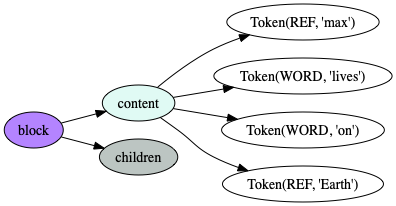

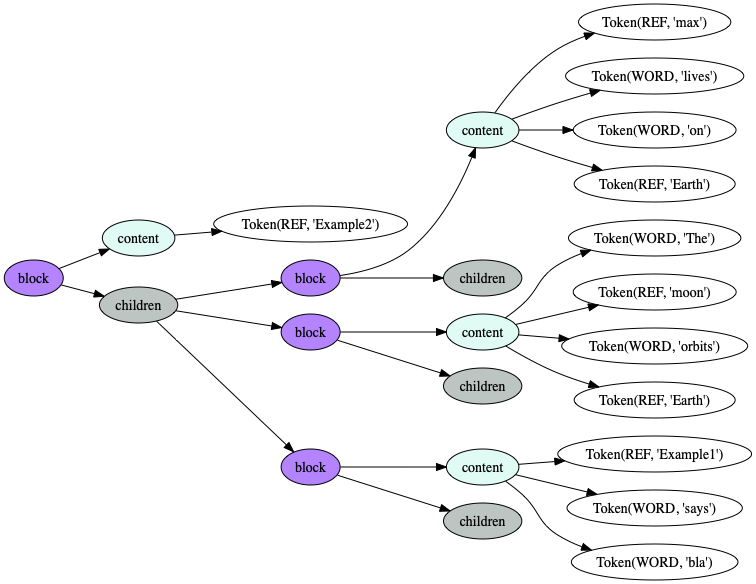

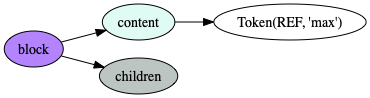

In [5]:
def resolve_ref_occurences(ref_text, blocks):
    occurences = []
    for bid in blocks.keys():
        b = blocks[bid]
        for ref in get_refs([b]):
            if ref == ref_text:
                occurences.append(b)
    return occurences


def resolve_ref_block(ref_text, all_blocks):
    occurences = resolve_ref_occurences(ref_text, all_blocks)
    block = None
    if ref_text in all_blocks.keys(): # Is a path to a block
        return all_blocks[ref_text]
    else:
        for b in occurences:
            block_text = b.content
            if len(block_text) == 1 and block_text[0] == ref_text:
                block = b
    if block is None and len(occurences) > 0: # construct an empty ref
        block = Block(content=[Token('REF', value=ref_text)])
    return block
    

resolve_ref_block('/0/0', all_blocks).show()
resolve_ref_block('Example2', all_blocks).show()
resolve_ref_block('max', all_blocks).show()


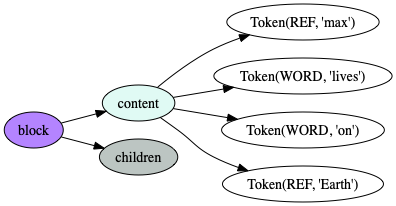

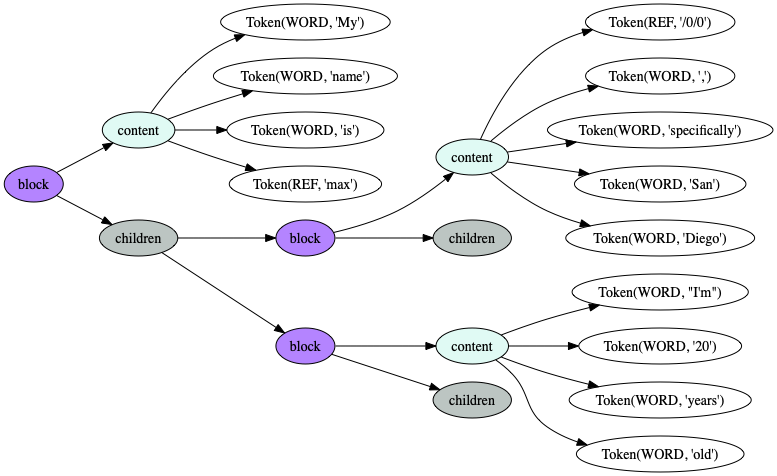

In [25]:
for b in resolve_ref_occurences('max', all_blocks):
    b.show()